# 

# Programming Assignment 2

Written by
Ramon Leiser
Tor Groje

In [2]:
%load_ext line_profiler
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import spdiags, kron, eye, linalg
from scipy.sparse.linalg import  spsolve
n_run = 1

## Constructing the matrices

We construct the matrices mainly using the `spdiags` function, which allows us to place vectors at the (off) diagonal entries of a matrix and then by taking their Kronecker product with `kron`. Overrun in `spdiags` on the offdiagonals is clipped at the end.

In [3]:
def A_matrix(n):
    ones = np.ones(n-1);
    T = spdiags([-ones,8*ones,-ones], [-1,0,1])
    S = spdiags([ones, ones, ones], [-1,0,1])
    return 3*n*kron(eye(n-1), T) - 3*n*kron(spdiags([ones, ones], [-1, 1]), S)


def M_matrix(n):
    ones = np.ones(n-1);
    Q = spdiags([ones, 4*ones, ones], [-1,0,1])
    return 1/n*kron(Q, Q/4)

A_matrix(4).toarray()

array([[ 96., -12.,   0., -12., -12.,   0.,   0.,   0.,   0.],
       [-12.,  96., -12., -12., -12., -12.,   0.,   0.,   0.],
       [  0., -12.,  96.,   0., -12., -12.,   0.,   0.,   0.],
       [-12., -12.,   0.,  96., -12.,   0., -12., -12.,   0.],
       [-12., -12., -12., -12.,  96., -12., -12., -12., -12.],
       [  0., -12., -12.,   0., -12.,  96.,   0., -12., -12.],
       [  0.,   0.,   0., -12., -12.,   0.,  96., -12.,   0.],
       [  0.,   0.,   0., -12., -12., -12., -12.,  96., -12.],
       [  0.,   0.,   0.,   0., -12., -12.,   0., -12.,  96.]])

## Solving the linear system

After initially writing this code block, we found that the solver would prefer `A` to be a compressed sparse column (row) matrix instead of the regular sparse datatype and so we convert it at the start. In `X` and `Y` we have arrays for the `x` and `y` coordinates respectively, with which we can easily produce the values of `f` around the grid. We use `reshape` to stack all this data into a long vector and then solve the system. Note that the function returns the solution as well as the grid (`(X,Y)`) the solution was computed on.

In [4]:
def problem_2_solve(n):
    print(f"Debug: Solving problem 1 for n={n}")
    A = A_matrix(n).tocsc()
    M = M_matrix(n)


    x = y = np.arange(1,n) / n
    X, Y = np.meshgrid(x,y)

    f = 5 * np.pi**2 * np.sin(2*np.pi*X)*np.sin(np.pi*Y)
    b = f.reshape(((n-1)**2, 1))
    
    prod = M.dot(b)
    return linalg.spsolve(A, prod), (X,Y)

ns = [4,8,16,32,64]
us = [ problem_2_solve(n) for n in ns ]

Debug: Solving problem 1 for n=4
Debug: Solving problem 1 for n=8
Debug: Solving problem 1 for n=16
Debug: Solving problem 1 for n=32
Debug: Solving problem 1 for n=64


The solution is easily plotted, again using our coordinate arrays `X` and `Y`.

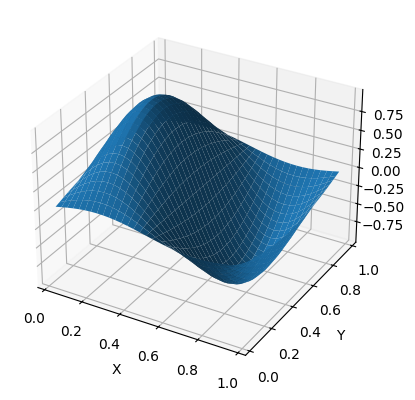

In [5]:
def problem_2_plot(u, XY):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    ax.plot_surface(XY[0],XY[1],u.reshape(XY[0].shape))
    return fig
problem_2_plot(*us[3]);

## Generating the analytic solution

First we implemented the function $\phi$ as `phi_eval`. With it, we compute $u$ at a given point `(x,y)` within a square with corner `(i,j)` on the mesh. For this, we first have to check if the vertices of the mesh square with the corner `(i,j)` are still within the grid, for otherwise they should not contribute to $u$. (Outside of the mesh, there are no weights for the functions anyways.) 

In [7]:
def phi_eval(x,k,n):
    return (k-1 < x*n)*(x*n < k  )* (1 - k + x*n) \
        +  (k   < x*n)*(x*n < k+1)* (1 + k - x*n)#The first two brackets are logic conditions, the last gives the value to the function.

def u_eval(x,y,U,i,j,n):
    I, J = np.meshgrid([i,i+1],[j, j+1])
    mask = (I > 0) * (I < n) * (J > 0) * (J < n) #Element-wise logic OR
    I = I[mask]
    J = J[mask]
    
    values = phi_eval(x,I,n)*phi_eval(y,J,n)
    values = values * U[(J-1)*(n-1) + (I-1)]
    return np.sum(values)

i,j = 16,16
u_eval((2*i + 1)/(2*ns[n_run]),(2*j + 1)/(2*ns[n_run]),us[n_run][0],i,j,ns[n_run])
#%lprun -f u_eval u_eval((2*i + 1)/(2*ns[n_run]),(2*j + 1)/(2*ns[n_run]),us[n_run][0],i,j,ns[n_run])

0.0

In a similar fashion we compute the gradient. For this we make use of the product rule and the derivative of $\phi$, `phi_grad_eval`.

In [8]:
def phi_grad_eval(x,k,n):
    return (k-1 < x*n)*(x*n < k  )* n \
        +  (k   < x*n)*(x*n < k+1)* (-n)
    
def u_grad_eval(x,y,u,i,j,n):
    I, J = np.meshgrid([i,i+1],[j, j+1])
    mask = (I > 0) * (I < n) * (J > 0) * (J < n)
    I = I[mask]
    J = J[mask]
    U = u[(J-1)*(n-1) + (I-1)]
    
    x_values = U * phi_grad_eval(x,I,n)*phi_eval(y,J,n)
    y_values = U * phi_eval(x,I,n)*phi_grad_eval(y,J,n)
    return np.array([np.sum(x_values), np.sum(y_values)])
   

i = j = ns[n_run]//2

 
u_grad_eval((2*i + 1)/(2*ns[n_run]),(2*j + 1)/(2*ns[n_run]),us[n_run][0],i,j,ns[n_run])

array([-5.20975691,  0.20612992])

## Computing errors of the finite element solution

To compute the error, we simply integrate either the `L2_error_fun` or `H1_error_fun` over the entire mesh, subdivided into the individual squares using the `total_error` function. This is rather slow, as for each mesh square, the `dblquad` function calls `u_eval` (resp. `u_grad_eval`) many times.

_Warning_: execution of the below block might take 5 minutes.

In [9]:
import itertools


def u(x,y):
    return np.sin(2*np.pi*x)*np.sin(np.pi*y)
def u_grad(x,y):
    return np.pi*np.array([2*np.cos(2*np.pi*x)*np.sin(np.pi*y),
                           np.sin(2*np.pi*x)*np.cos(np.pi*y)])
#def error_computation(n,U,):
#    for i,j in itertools.product(range(1,n), range(1,n)):
#        (u(x,y) - u_eval(x,y,U,i,j))**2
        
def L2_error_fun(y, x, U, n, i, j):
    return (u(x,y) - u_eval(x,y,U,i,j, n))**2

def H1_error_fun(y, x, U, n, i, j):
    return np.sum((u_grad(x,y) - u_grad_eval(x, y, U, i, j, n))**2)

def total_error(U,n,error_fun):     
    # default_epsabs = 1.49e-8   
    h = 1/n
    def mesh_integrate(i, j):     
        x_low = i/n
        y_low = j/n
        return scipy.integrate.dblquad(error_fun, x_low, x_low + h, y_low, y_low + h, args = (U, n, i, j), epsabs = 1.49e-8)

    mesh_tuples = itertools.product(range(0,n), range(0,n))

    return np.sqrt(np.sum([ mesh_integrate(i,j)[0] for (i,j) in mesh_tuples ]))

for i in range(4):
    print("Error for n = %i" % ns[i])
    print("L2- rr:", total_error(us[i][0],ns[i],L2_error_fun))
    print("H1-rr:", total_error(us[i][0],ns[i],H1_error_fun))
    print()
    
                                

Error for n = 4
L2- rr: 0.1792788455180071
H1-rr: 1.5991101578363316

Error for n = 8
L2- rr: 0.05246993478170822
H1-rr: 0.7604975029470463

Error for n = 16
L2- rr: 0.013637650586360062
H1-rr: 0.3707808121100696

Error for n = 32
L2- rr: 0.00344259714549818
H1-rr: 0.18402302784684987



## Plot of convergence

We plot the $L^2$ and $H^1$ errors on a log-log scale relative to $n$. This shows that the $L^2$ convergence is quadratic but that the $H^1$ convergence is linear. For reference, the function $\frac{1}{n^2}$ is also shown.

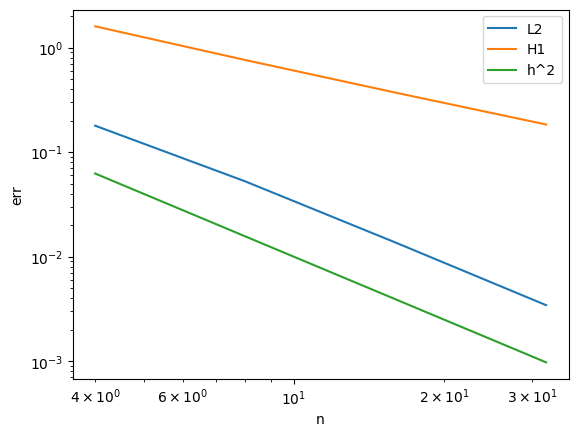

In [10]:
values = np.array([[ 0.1792788455180071, 1.5991101578363316],
[ 0.05246993478170822, 0.7604975029470463],
[0.013637650586360062, 0.3707808121100696],
[0.00344259714549818,0.18402302784684987]])

plt.loglog(ns[0:4], values[:,0], label='L2')
plt.loglog(ns[0:4], values[:,1], label='H1')
plt.loglog(ns[0:4], 1/(np.array(ns[0:4])**2), label='h^2')
plt.xlabel('n')
plt.ylabel('err')
plt.legend()